<div style="background:#FFFFAA">
<img src="logo.jpg", width=150, ALIGN="left", border=20>


<br>This code was tested with <br>
Python 3.8.5 |Anaconda custom (64-bit)| (default, Sep  4 2020, 02:22:02) (https://anaconda.org/)<br>
<i> Adapted for original code of Balázs Kégl</i> <br>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p>

In this challenge you are going to try to classify whether a picture of a lung is that of a pneumonia patient. The data in this notebook is taken from the activation layer of neural networks that where trained on the originial image data. You can try using this as an input for different ML techniques such as Support Vector Machines, Random Forest Classifiers or Neural Networks.
        

</div>

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
#model_dir = '../FILES/pretty_good_sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'

from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
# %load_ext autoreload
# %autoreload 2
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns; sns.set()
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import sklearn.model_selection
import numpy as np
import time

from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import sklearn.model_selection
import sklearn.metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.patches

import time
import os
import copy
from pathlib import Path
import shutil
import sys
import pickle

import random
# from PIL import Image, ImageDraw, ImageFont
import PIL
from sklearn.model_selection import train_test_split
import cv2
import scipy.ndimage.interpolation

from functools import partial


<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
</div>

In [3]:
import os
sample_imgs_dir = 'sample_images'
sample_imgs_names = os.listdir(sample_imgs_dir)

data_dir = 'cropped_images'
imgs_dir = 'cropped_images/crop'
imgs_names = os.listdir(sample_imgs_dir)

First we show you the original data, that is radiology images from healthy and sick individuals. This data was used to create the data that your classification will run on.

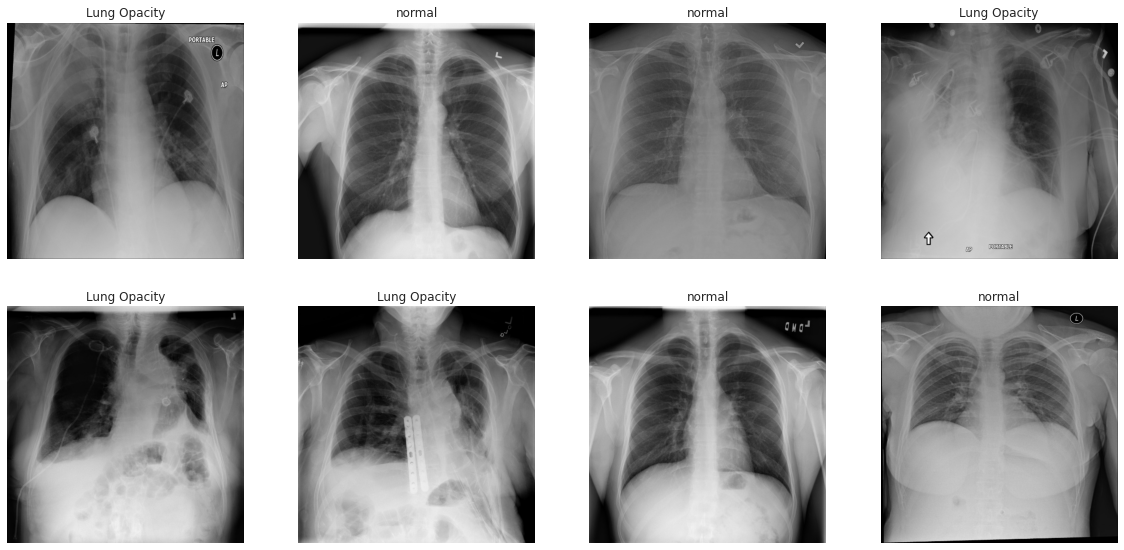

In [4]:
def show_images(images, rows=4, cols=4, figsize=(20, 20),title=None):
    figure = plt.figure(figsize=figsize)
    for idx, img in enumerate(images):
        label = img.split('_')[1].split('.')[0] 
        ax = plt.subplot(rows, cols, idx + 1)
        img = image.imread(os.path.join(sample_imgs_dir, img))
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        if idx > 6:
            break
    if title is not None:
        plt.title(title)
show_images(sample_imgs_names)

We have taken parts of the original image out of the originial images so that the model cannot rely on watermarks and artifacts from special radiology equipment.

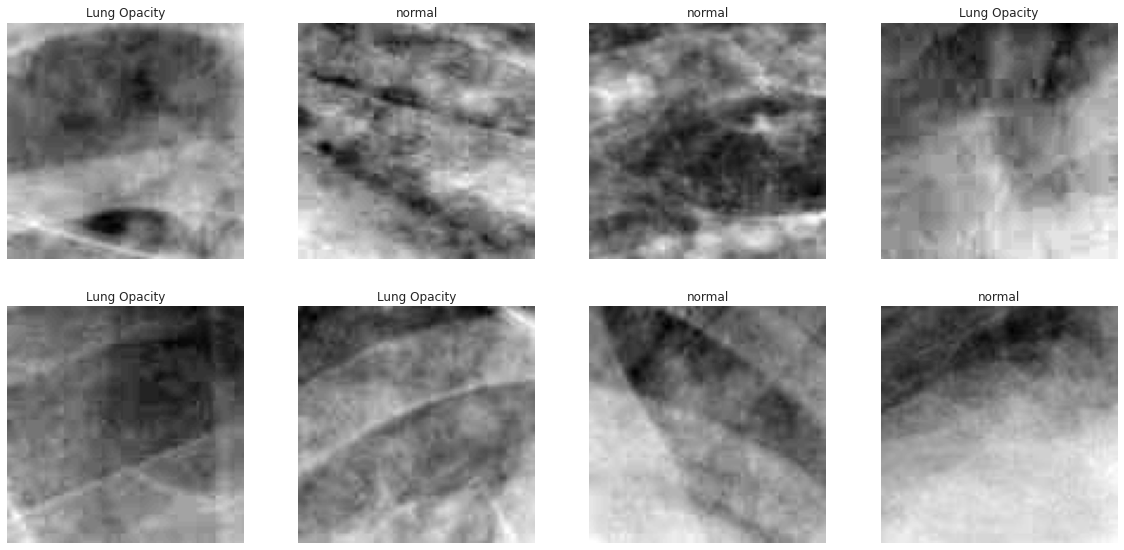

In [5]:
def show_images(images, imgs_dir, rows=4, cols=4, figsize=(20, 20),title=None):
    figure = plt.figure(figsize=figsize)
    for idx, img in enumerate(images):
        label = img.split('_')[1].split('.')[0] 
        ax = plt.subplot(rows, cols, idx + 1)
        img = image.imread(os.path.join(imgs_dir, str(idx+1) + ".jpg"))
        plt.imshow(img, cmap="gray")
        plt.title(label)
        plt.axis('off')
        if idx > 6:
            break
    if title is not None:
        plt.title(title)
show_images(imgs_names, imgs_dir)

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:

</div>

In [6]:
from pathlib import Path
crop_dir = Path(data_dir)
metadata = pd.read_csv(crop_dir.joinpath('metadata_train.csv'))
display(metadata.describe())
display(metadata.sample(5))
print(metadata.shape)

#TODO drop patient ID column

,x,y,width,height,Target,boxes,xcenter,ycenter
count,4394.000000,4394.000000,4394.000000,4394.000000,10863.000000,10863.000000,4394.000000,4394.000000
mean,385.778789,376.680701,215.949704,312.591944,0.404492,1.237043,493.753641,532.976673
std,204.228138,149.385785,58.947321,153.808845,0.490816,0.448264,205.116965,117.199309
min,2.000000,2.000000,54.000000,45.000000,0.000000,1.000000,87.500000,138.500000
25%,204.000000,257.250000,174.000000,191.000000,0.000000,1.000000,309.500000,456.000000
50%,304.000000,379.500000,214.000000,282.000000,0.000000,1.000000,396.250000,534.500000
75%,590.000000,488.000000,256.000000,414.000000,1.000000,1.000000,704.875000,611.875000
max,817.000000,881.000000,467.000000,942.000000,1.000000,4.000000,899.500000,945.000000


,patientId,x,y,width,height,Target,class,boxes,path,xcenter,ycenter,new_path
2426,42d93c57-38ba-47f1-a113-6bb961a71c00,NaN,NaN,NaN,NaN,0,Normal,1,../input/stage_2_train_images/42d93c57-38ba-47...,NaN,NaN,7557.jpg
7225,ae5d10d8-1ed8-456f-886b-8689db2a0ee8,571.0,404.0,263.0,270.0,1,Lung Opacity,1,../input/stage_2_train_images/ae5d10d8-1ed8-45...,702.5,539.0,3994.jpg
9535,de0ee373-dd0c-4f75-aa2c-c356d203696e,181.0,240.0,215.0,211.0,1,Lung Opacity,1,../input/stage_2_train_images/de0ee373-dd0c-4f...,288.5,345.5,5444.jpg
7852,b8960e8b-c5da-4d8f-b4c3-bc4f3706a061,NaN,NaN,NaN,NaN,0,Normal,1,../input/stage_2_train_images/b8960e8b-c5da-4d...,NaN,NaN,12237.jpg
1672,35a60fb3-459a-43a6-9c1f-066578ca5d63,209.0,433.0,226.0,268.0,1,Lung Opacity,1,../input/stage_2_train_images/35a60fb3-459a-43...,322.0,567.0,1185.jpg


(10863, 12)


In [7]:
#https://github.com/utkuozbulak/pytorch-custom-dataset-examples/blob/master/README.md#incorporating-pandas
    
class ImgDataset(torch.utils.data.Dataset):
    def __init__(self,df,img_dir, transform):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.transform = transform
        # First column contains the image paths
        self.df=df
        self.img_dir=img_dir
        self.image_arr = np.asarray(self.df.iloc[:, -1])
        self.label_arr = np.asarray(self.df.iloc[:, 5])

        self.data_len = len(self.df.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        img_as_img = PIL.Image.open(self.img_dir.joinpath(single_image_name)).convert("RGB")
        img_transformed = self.transform(img_as_img) if self.transform else img_as_img
        
        single_image_label = self.label_arr[index]

        return img_transformed, single_image_label

    def __len__(self):
        return self.data_len

In [8]:
train_df, valid_df = sklearn.model_selection.train_test_split(
    metadata, test_size=0.2, 
    random_state=420, shuffle=True, 
    stratify=metadata['Target'],
)

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_ds=ImgDataset(train_df,Path(imgs_dir), transform)
valid_ds=ImgDataset(valid_df,Path(imgs_dir), transform)

print(len(train_ds))
print(len(valid_ds))

8690
2173


<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [10]:
from model import model
#M = model()
#trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
#M = M.load(trained_model_name)

In [11]:
batch_size = 64
dataloaders = {'val':torch.utils.data.DataLoader(valid_ds, batch_size=batch_size,
                                             shuffle=False, 
                                            #  num_workers=4,
                                             )
              ,
              'train':torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                             shuffle=True, 
                                            #  num_workers=4,
                                             )
               }

dataset_sizes = {'val': len(valid_ds),
                 'train':len(train_ds)
                 }
#class_names=metadata['class'].unique() 
# class_names=['No opacity','Opacity']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
def get_model():
    model = models.mobilenet_v2(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)
    # model = models.resnet18(pretrained=True)
    # num_ftrs = model.fc.in_features
    # model.fc=nn.Linear(num_ftrs, len(class_names))
    return model.to(device)

In [24]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_history = []
    score_history = []
    train_loss, train_score, valid_loss, valid_score = [], [], [], []

    for epoch in range(num_epochs):
        print('\n','Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # end dataloader loop

            if phase == 'train':
                scheduler.step()
#                 loss_history.append(running_loss)
#                 score_history.append(running_corrects)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_history, score_history = (train_loss, train_score) if phase == 'train' else (valid_loss, valid_score)
            loss_history.append(epoch_loss)
            score_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        # end phase loop

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return dict(   
        model = model,
        train_loss = train_loss,
        train_score = train_score,
        valid_loss = valid_loss,
        valid_score = valid_score,
    )

In [29]:
#model_conv = get_model()
M = model()

#criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer_conv = optim.SGD(M.learner.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


#train_result_conv = train_model(M.learner, criterion, optimizer_conv,
#                       exp_lr_scheduler, num_epochs=5)
M.fit(dataloaders)


 Epoch 0/0
----------
train Loss: 0.5006 Acc: 0.7535
val Loss: 0.4531 Acc: 0.7823
Training complete in 2m 8s
Best val Acc: 0.782329


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [ ]:
#M.save(trained_model_name)                 

In [ ]:
def predict_batch(model, inputs):
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    return predictions

def get_prediction_target(model, dataloader):
    targets = []
    predictions = []
    for inpt, target in dataloader:
        predictions.append(predict_batch(M.learner, inpt.to(device)))
        targets.append(target)
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    
    return predictions, targets
valid_predictions, valid_targets = get_prediction_target(M.learner, dataloaders['val'])

In [ ]:
valid_predictions

In [ ]:
valid_targets

In [ ]:
'''
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*
'''

In [ ]:
M.save()

In [ ]:
M = M.load("./sample_code_submission/MobileNet2_save")

<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

In [ ]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

We build an awesome evaluation heatmao. You can use it to see what your model is focusing on!

In [ ]:
#!pip install captum
import captum.attr

In [ ]:
def format_image_for_display(img_tensor):
    return img_tensor.numpy().transpose((1, 2, 0))

In [ ]:
def predict_batch(model, inputs):
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    return predictions

In [ ]:
sample_images, sample_labels = next(iter(dataloaders['val']))
sample_predictions = predict_batch(M.learner, sample_images.to(device))

class_names = ['normal', 'opcacity']

In [ ]:
#model = M
layer_gradcam = captum.attr.LayerGradCam(M.learner, list(M.learner.features.children())[-1])


def plot_gradcam(layer_gradcam=layer_gradcam, index=0):
    gradcam_attr = layer_gradcam.attribute(sample_images[index].unsqueeze(0).to(device), sample_labels[index])

    # upsample CAM to original image size
    gradcam_upsample = scipy.ndimage.interpolation.zoom(
      gradcam_attr.squeeze(0).cpu().detach().numpy(), 
      np.array(sample_images[0].shape)/np.array(gradcam_attr.shape[1:]),
    )

    _ = captum.attr.visualization.visualize_image_attr_multiple(
    np.transpose(gradcam_upsample, (1,2,0)), 
    format_image_for_display(sample_images[index]),
    methods = 'original_image blended_heat_map'.split(' '),
    signs='all all'.split(' '),
    alpha_overlay=0.6,
    cmap='viridis',
    titles=[f'truth: {class_names[sample_labels[index]]}', f'prediction: {class_names[sample_predictions[index]]}'],
    show_colorbar=True
  )


In [ ]:
plot_gradcam(index=7)

<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [ ]:
#print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
#print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(valid_predictions.cpu(), valid_targets.cpu()))
#print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(valid_targets, valid_targets))

You can add here other scores and result visualization.

In [ ]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(Y_train, Y_hat_train)
confusion_matrix(valid_predictions.cpu(), valid_targets.cpu())

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
#scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
#scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))

#print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [ ]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [ ]:
scoring_output_dir = 'scoring_output'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [ ]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)